In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device ( "cuda:0" if torch.cuda.is_available() else "cpu" )
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

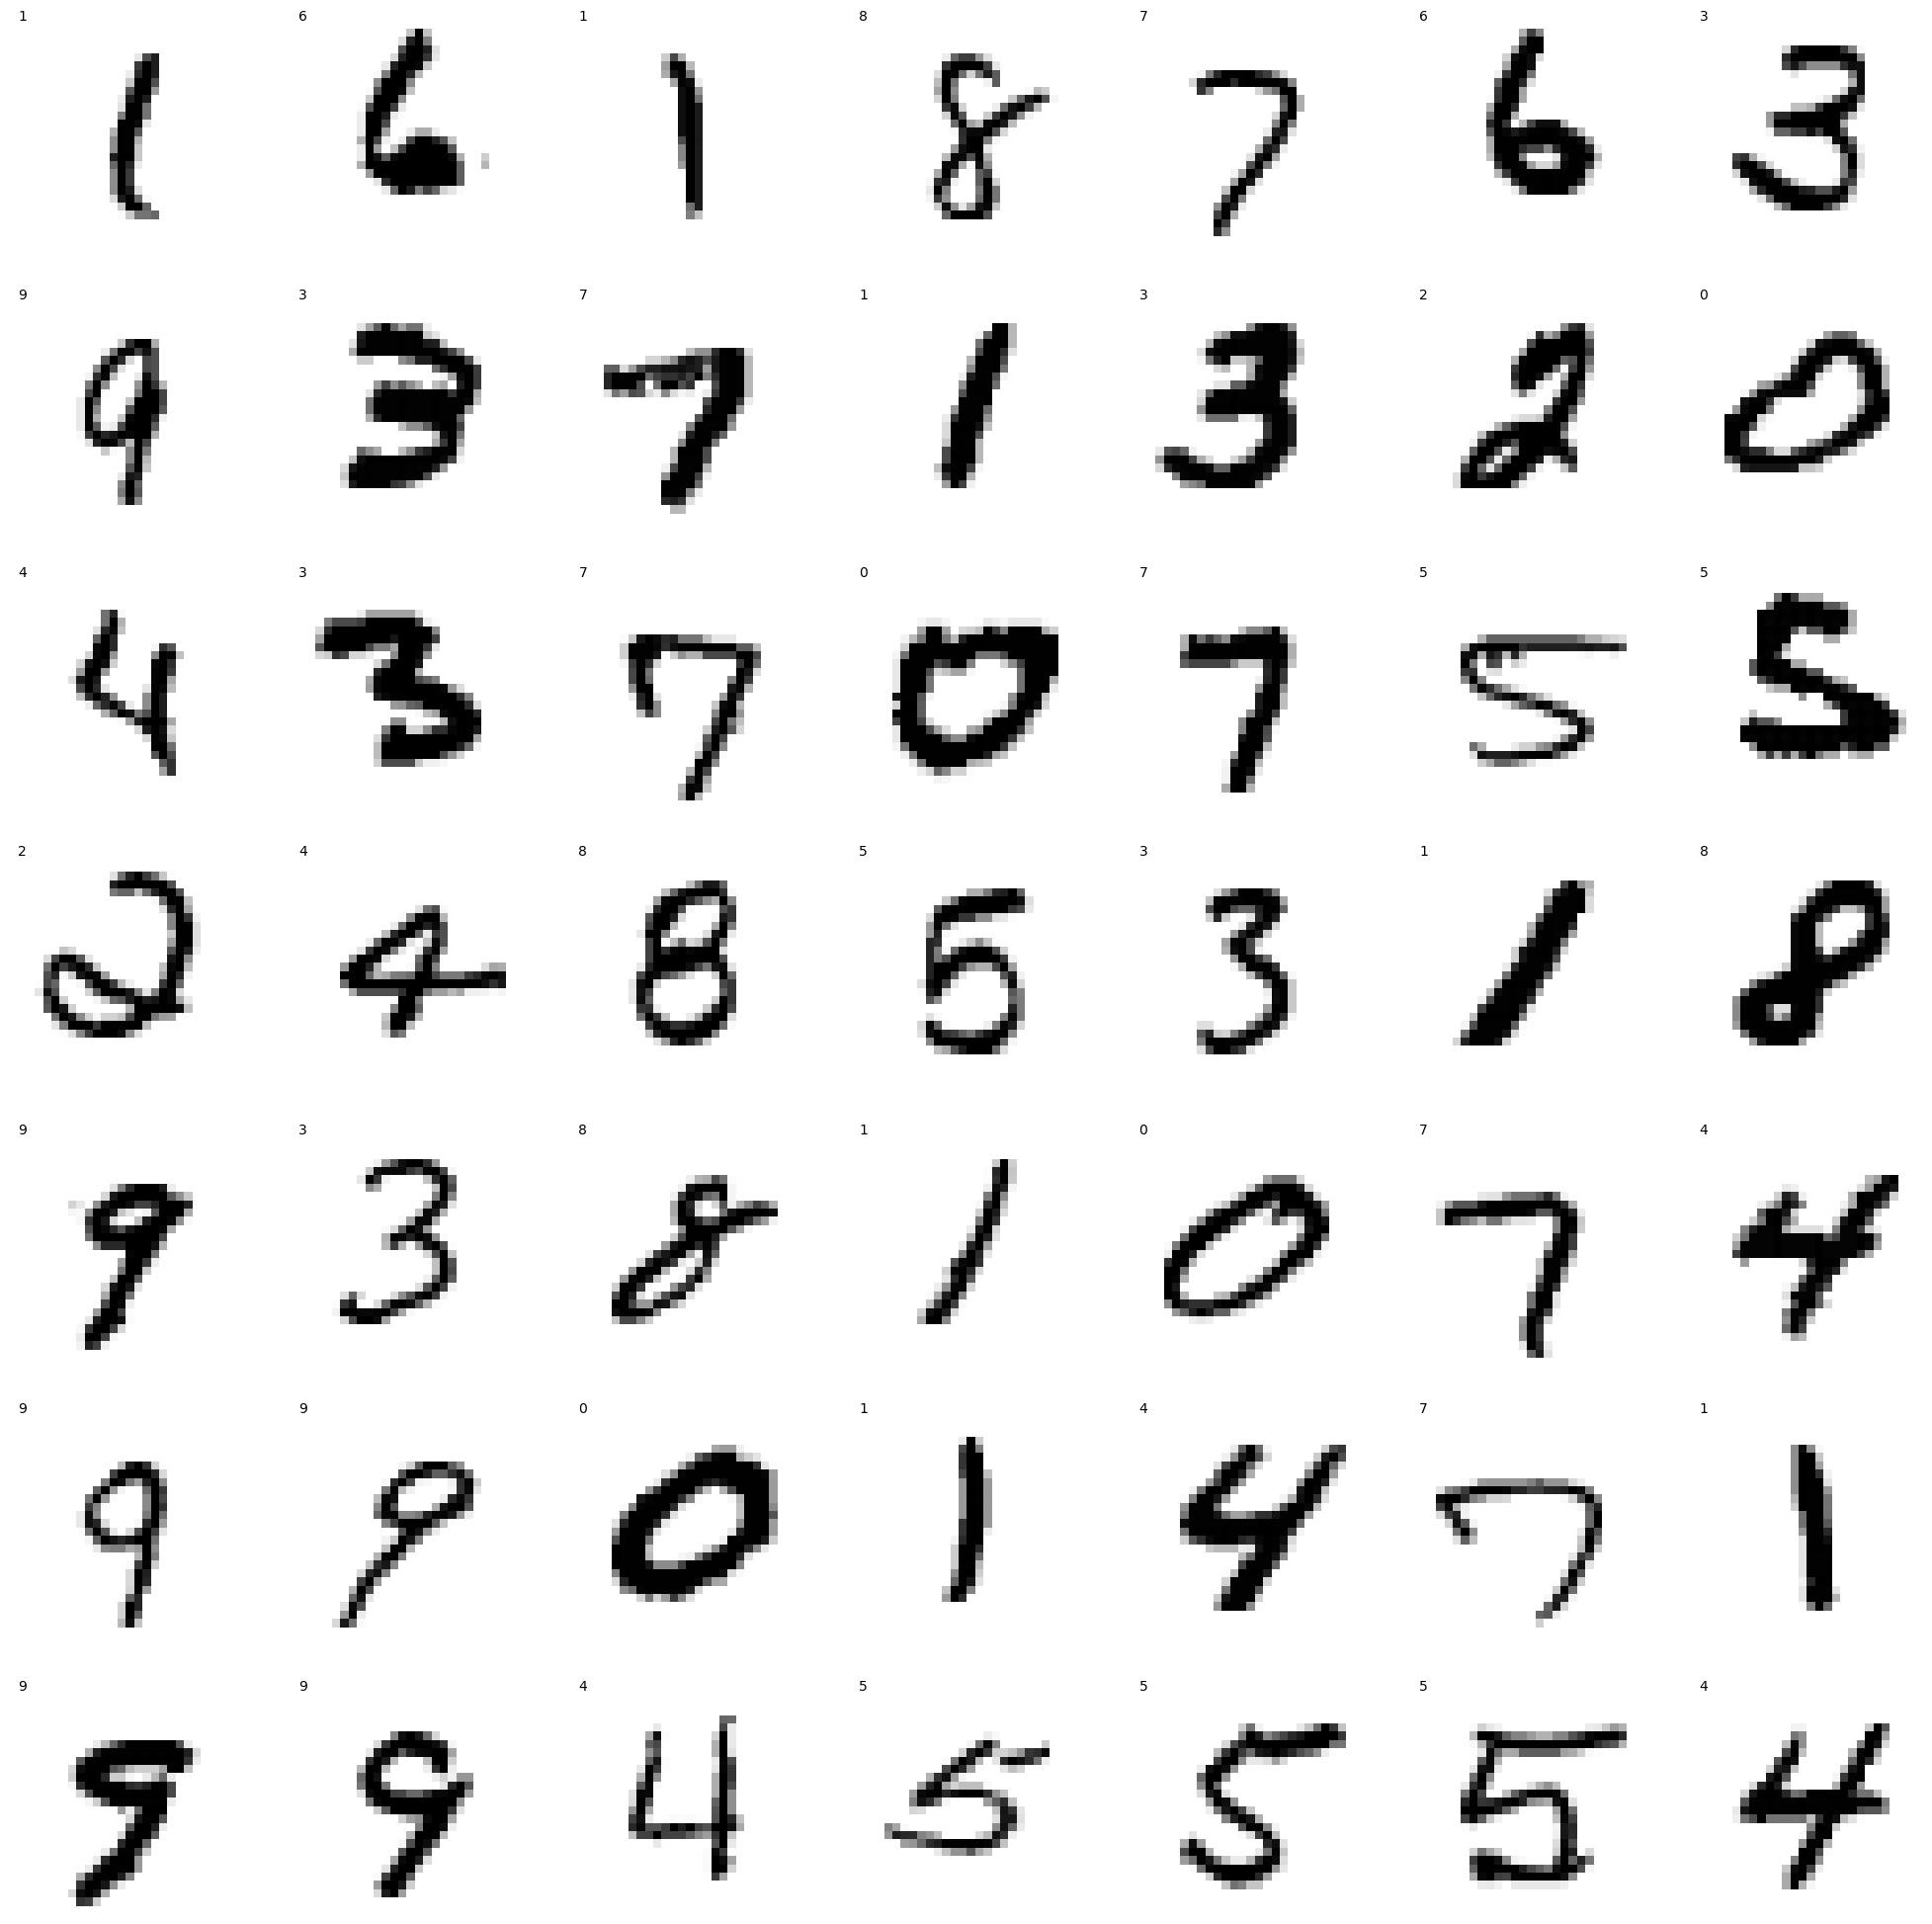

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axs = plt.subplots(7, 7, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.text(0.5,0.5,labels[i].item())
    ax.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    ax.axis('off')

In [51]:
# Вычисление статистик по изображениям
print(f"Размер изображений: {train_dataset[0][0].size()}")
print(f"Минимальное значение пикселя: {train_dataset[0][0].min()}")  
print(f"Максимальное значение пикселя: {train_dataset[0][0].max()}")

Размер изображений: torch.Size([1, 28, 28])
Минимальное значение пикселя: -1.0
Максимальное значение пикселя: 1.0


In [15]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


def binarize_image(image, threshold=0.5):
    image[image >= threshold] = 1.0
    image[image < threshold] = 0.0
    return image

# Определение нового датасета с бинаризованными изображениями
class BinarizedMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.mnist_dataset = torchvision.datasets.MNIST(root=root, train=train, download=True, transform=transform)
        
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]
        binarized_image = binarize_image(image)
        return binarized_image, label

# Загрузка бинаризованного датасета
train_data = BinarizedMNIST(root='data/', train=True, transform=ToTensor())
test_data = BinarizedMNIST(root='data/', train=False, transform=ToTensor())

# Создание загрузчиков данных
train_loader_new = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_new = DataLoader(test_data, batch_size=64, shuffle=False)

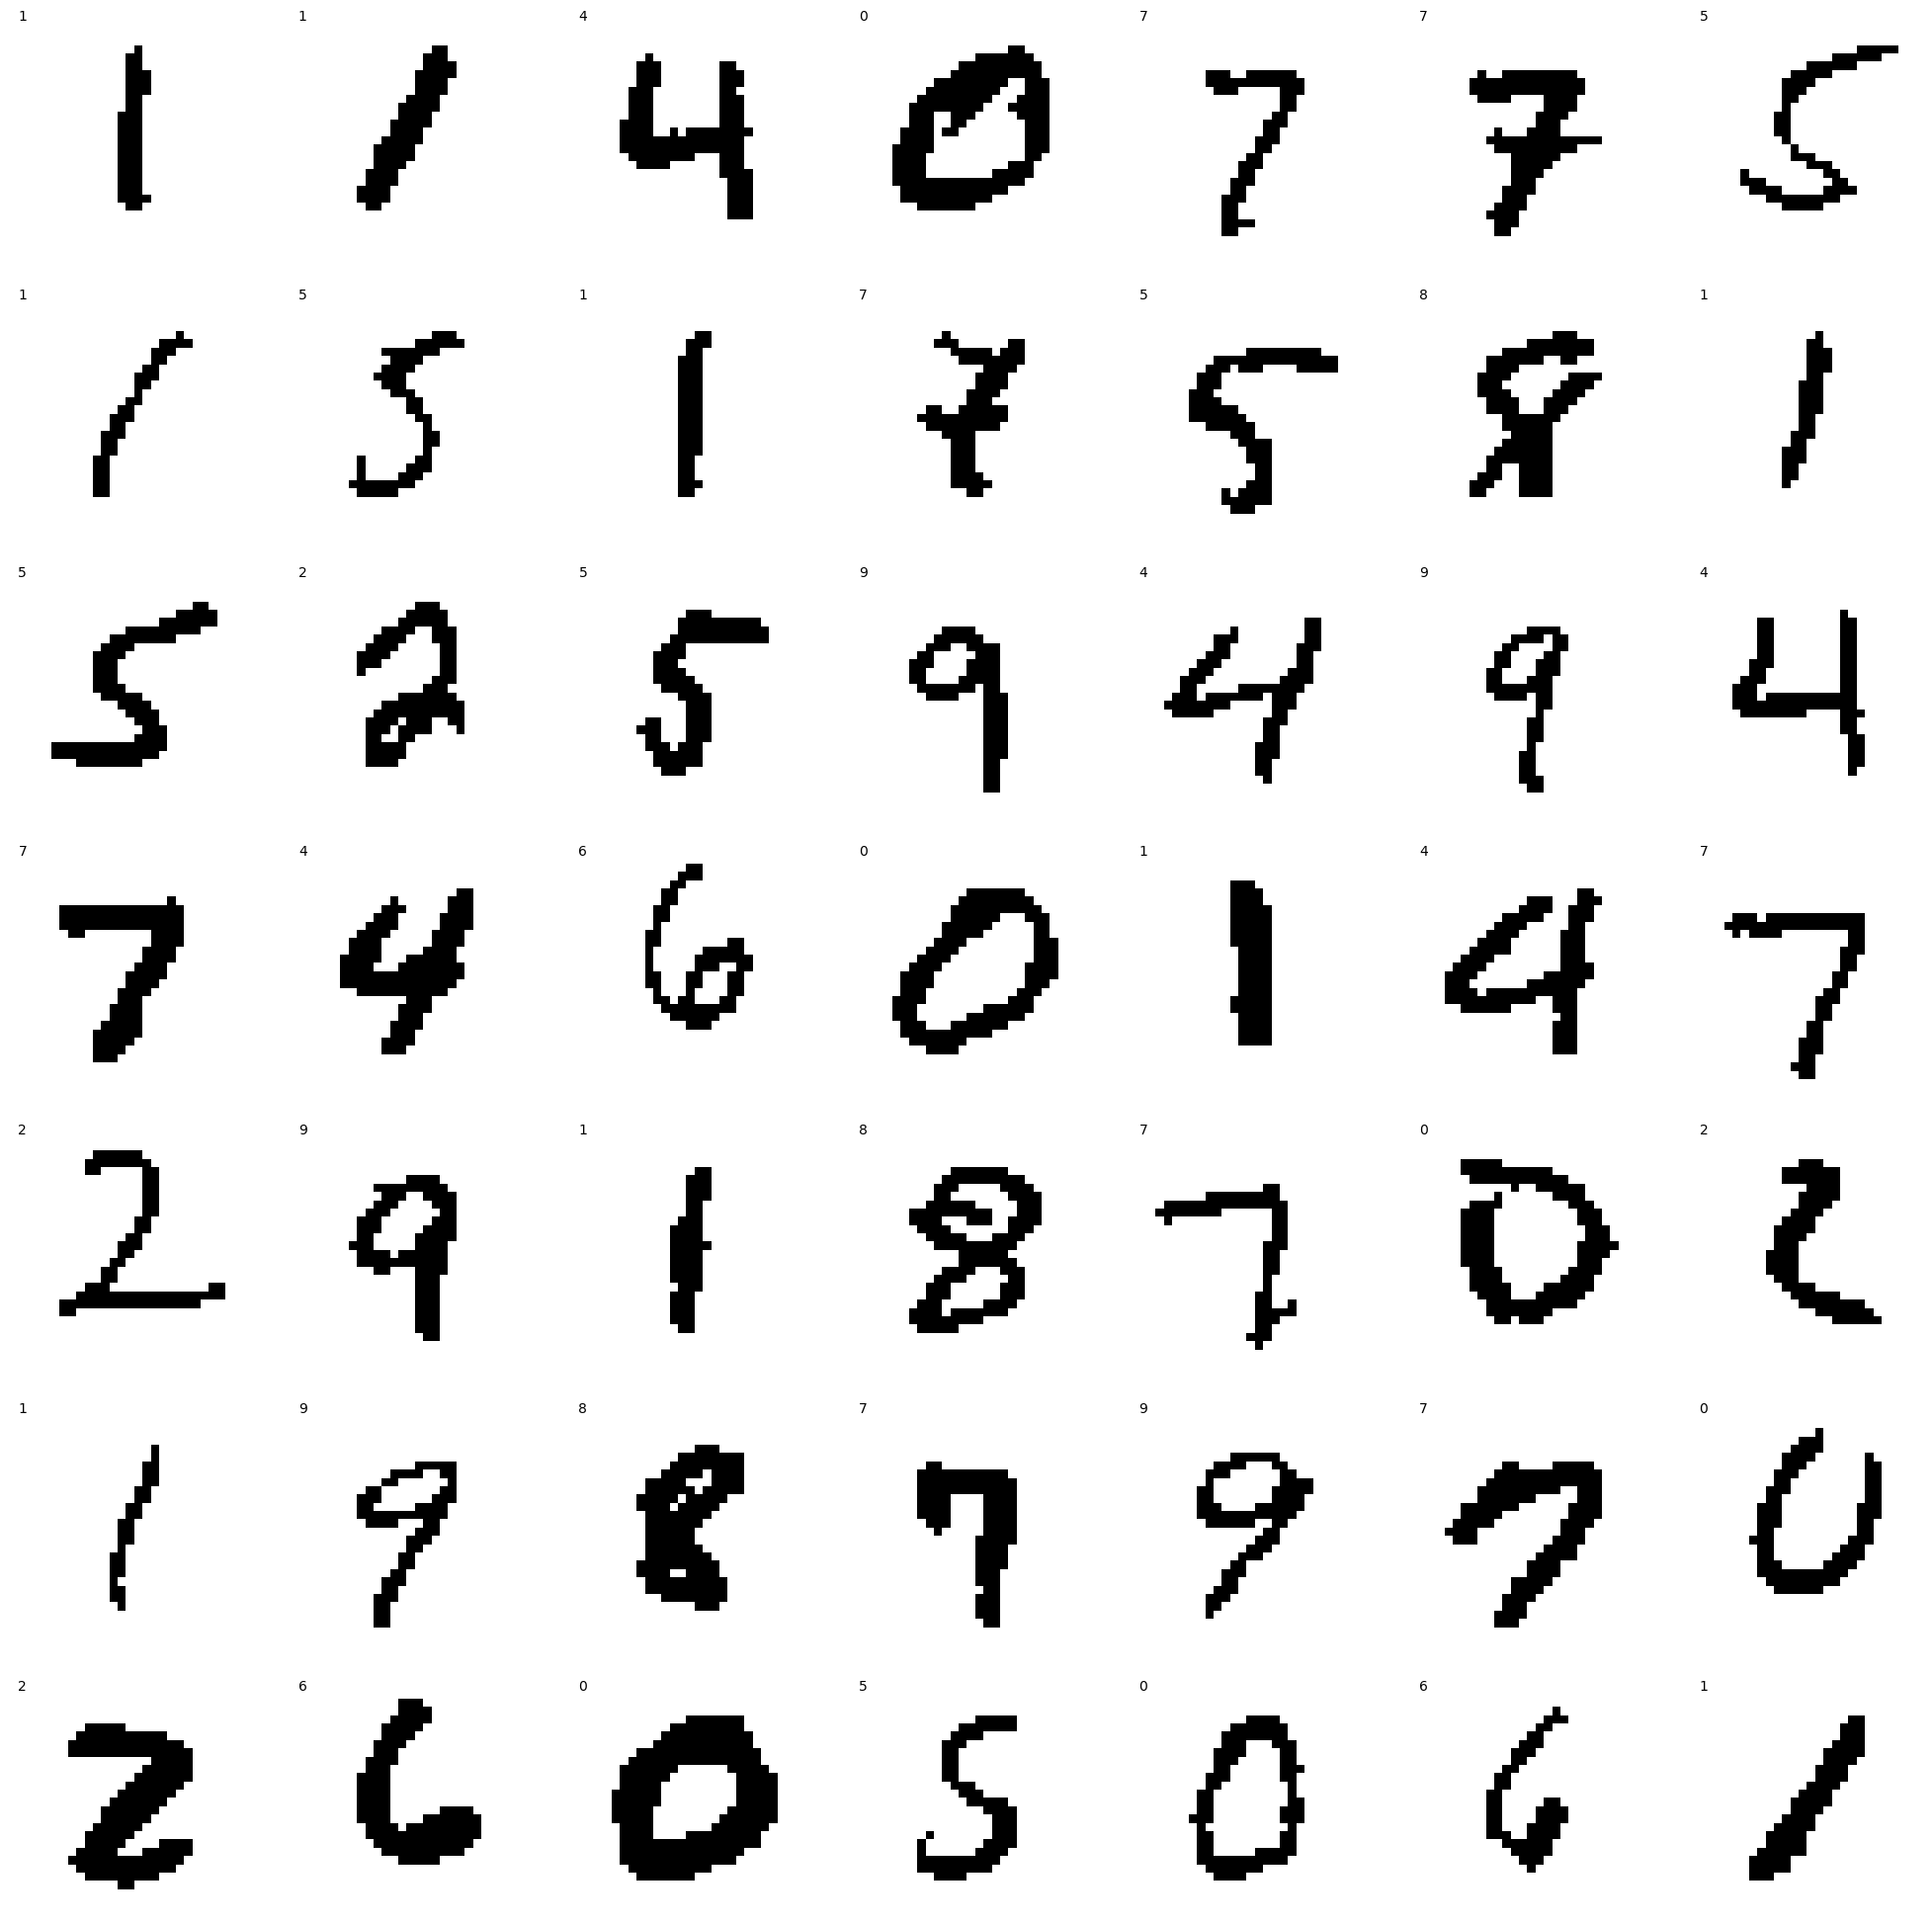

In [16]:
dataiter = iter(train_loader_new)
images, labels = next(dataiter)

fig, axs = plt.subplots(7, 7, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.text(0.5,0.5,labels[i].item())
    ax.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    ax.axis('off')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 128)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(64, 10)
        self.act3 = nn.LogSoftmax(dim=1)


    def forward(self, x):
        """
        params:
            x (torch.Tensor): данные, поданные на вход сети
        """
        x = x.view(-1, 28 * 28)

        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

In [7]:
import tqdm
from tqdm.auto import tqdm

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    '''
    args:
        model - модель нейронной сети
        loader - DataLoader для обучающей выборки
        criterion - функция потерь, взятая из модуля `torch.nn`
        optimizer - оптимизатор, взятый из модуля `torch.optim`
        num_epoch - количество эпох обучения.
    '''
    for epoch in tqdm(range(num_epoch)):
        epoch_loss = []

        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Compute predictions
            with torch.autocast(device_type="cuda"):
                y_pred = model(X_batch)

                # Compute loss
                loss = criterion(y_pred, y_batch)
                epoch_loss.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_loss)}')

    return model

In [10]:
model = Net()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [62]:
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [63]:
train_stochastic(model, train_loader, criterion, optimizer, num_epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 0.38368087098288384
Epoch 2, Loss: 0.18461518455793197
Epoch 3, Loss: 0.13371049423120232
Epoch 4, Loss: 0.10949474112438495
Epoch 5, Loss: 0.09104512366793875
Epoch 6, Loss: 0.07838899741368269
Epoch 7, Loss: 0.07035232205187152
Epoch 8, Loss: 0.062106638273069344
Epoch 9, Loss: 0.05703157325387438
Epoch 10, Loss: 0.05176123910389199
Epoch 11, Loss: 0.04834905296852286
Epoch 12, Loss: 0.043334558570373015
Epoch 13, Loss: 0.04007447530927041
Epoch 14, Loss: 0.03820201026639149
Epoch 15, Loss: 0.036926562227914406
Epoch 16, Loss: 0.032846625709159014
Epoch 17, Loss: 0.03361597450879856
Epoch 18, Loss: 0.030386586113285752
Epoch 19, Loss: 0.02696463557252101
Epoch 20, Loss: 0.029686827450689058
Epoch 21, Loss: 0.02413202283509069
Epoch 22, Loss: 0.028821799480023662
Epoch 23, Loss: 0.023102285879337898
Epoch 24, Loss: 0.021974005258400372
Epoch 25, Loss: 0.019299339802481105
Epoch 26, Loss: 0.022020804130374102
Epoch 27, Loss: 0.01873970865321397
Epoch 28, Loss: 0.02164544

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [64]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 97.68%


In [8]:
model2 = Net()

In [9]:
model2.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [16]:
train_stochastic(model2, train_loader_new, criterion, optimizer, num_epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 0.023325947882978332
Epoch 2, Loss: 0.009019748234421662
Epoch 3, Loss: 0.007217939794336641
Epoch 4, Loss: 0.0063183785880878114
Epoch 5, Loss: 0.005963996576478122
Epoch 6, Loss: 0.0055614040092748646
Epoch 7, Loss: 0.005403514785132441
Epoch 8, Loss: 0.005202887319201077
Epoch 9, Loss: 0.00502040662028314
Epoch 10, Loss: 0.005120833202174241
Epoch 11, Loss: 0.004702849173442168
Epoch 12, Loss: 0.00466806241628622
Epoch 13, Loss: 0.004622266757164548
Epoch 14, Loss: 0.00472553556938929
Epoch 15, Loss: 0.0044406433854745336
Epoch 16, Loss: 0.004416045307020914
Epoch 17, Loss: 0.00442066766941937
Epoch 18, Loss: 0.00441712897094825
Epoch 19, Loss: 0.004380389899534424
Epoch 20, Loss: 0.004431284322408694
Epoch 21, Loss: 0.004459573353997243
Epoch 22, Loss: 0.0043481888145463325
Epoch 23, Loss: 0.004318021992578592
Epoch 24, Loss: 0.004275856887452951
Epoch 25, Loss: 0.004451316112354539
Epoch 26, Loss: 0.004667176607349761
Epoch 27, Loss: 0.004428879679918866
Epoch 28, L

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [18]:
model2.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_new:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 97.42%
